# 新闻分类（基于多项式模型的贝叶斯）

In [65]:
import os
import jieba
import random
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

## 文本预处理

In [97]:
def TextProcessing(folder_path, test_size = 0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
    
    # 遍历每个子文件夹
    for folder in folder_list:
        # join函数的作用是拼接字符串
        new_folder_path = os.path.join(folder_path, folder) # 根据子文件夹，生成新路径
        files = os.listdir(new_folder_path)
        
        j = 1
        # 遍历每个txt文件
        for file in files:
            if j > 100: # 每个txt样本数最多100个
                break;
            with open(os.path.join(new_folder_path, file), 'r', encoding = 'utf-8') as f:
                raw = f.read()
                
            word_cut = jieba.cut(raw, cut_all=False) # 精简模式，返回一个可迭代的generator
            word_list = list(word_cut)
            
            data_list.append(word_list)
            class_list.append(folder)
            j += 1
            
    data_class_list = list(zip(data_list, class_list)) # 将class_list拼接到data_list后面
    random.shuffle(data_class_list) # 将data_class_list乱序
    index = int(len(data_class_list) * test_size) + 1 # 训练集和测试集切分的索引值
    train_list = data_class_list[index:] # 训练集
    test_list = data_class_list[:index] # 测试集
    train_data_list, train_class_list = zip(*train_list) # 将标签和样本拆分开
    test_data_list, test_class_list = zip(*test_list)
    
    all_words_dict = {} # 统计训练集词频
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
                
    # 根据单词出现的次数降序排列
    all_words_tuple_list = sorted(all_words_dict.items(), key = lambda f:f[1], reverse=True)
    all_words_list, all_words_nums = zip(*all_words_tuple_list) # 解压缩
    all_words_list = list(all_words_list) # 转换成列表
    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

## 读取文件内容并去重

In [98]:
def makeWordsSet(words_file):
    words_set = set() # 创建set集合
    with open(words_file, 'r', encoding = 'utf-8') as f: # 打开文件
        for line in f.readlines(): # 一行一行读取
            word = line.strip()# 去回车
            if len(word) > 0:# 有文本，则添加到words_set中
                words_set.add(word)
    return words_set 

## 将文本向量化

In [99]:
def TextFeatures(train_data_list, test_data_list, feature_words):
    def text_features(text, feature_words):
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

## 文本特征选取

In [100]:
def words_dict(all_words_list, deleteN, stopwords_set = set()):
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000:
            break
        # 如果这个词不是数字 && 不是指定的停用词 && 单词长度大于1小于5，那么这个单词可以作为特征词
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1 < len(all_words_list[t]) < 5:
            feature_words.append(all_words_list[t])
        n += 1
    return feature_words

## 新闻分类

In [122]:
def TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list):
    classifier = MultinomialNB().fit(train_feature_list, train_class_list)
    test_accuracy = classifier.score(test_feature_list, test_class_list)
    return test_accuracy

In [123]:
# 文本预处理
folder_path = "Data/SogouC/Sample"
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path, test_size=0.2)

In [124]:
# 生成stopwords_set
stopwords_file = "Data/SogouC/stopwords_cn.txt"
stopwords_set = makeWordsSet(stopwords_file)

In [125]:
test_accuracy_list = []
# 需要去除一些高频词的原因是：高频词一般是标点符号、了、好、在、当然、是的等等，这些词对分类是没用的
# 但是具体要去除多少是不清楚的，所以才有了下面的实验，看到底去掉多少个高频词使得最后的准确率最高
deleteNs = range(0, 1000, 20) #0 20 40 60 ... 980
for deleteN in deleteNs:
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
    test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
    test_accuracy_list.append(test_accuracy)

In [126]:
#ave = lambda c: sum(c) / len(c)
#print(ave(test_accuracy_list))

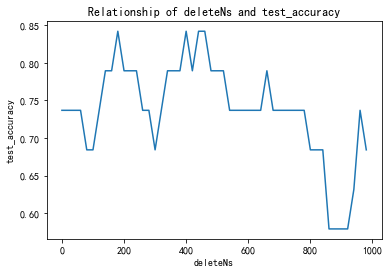

In [127]:

plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()

从上图看出，当去掉前200左右的高频词时，预测准确率最高